### Sentiment Analysis Using Logistic Regression and Baseline Model

In [3]:
# load in the clean data
import pandas as pd
import numpy as np  

from src.paths import TRANSFORMED_DATA_DIR

In [4]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / 'cleaned_sentiments.parquet')
df.head()

,recommended,cleaned
0,1,Very good flight following an equally good fli...
1,1,An hours delay due to late arrival of the inco...
2,0,I booked through BA because Loganair dont have...
3,0,British airways lost bags in LHR then found th...
4,0,The check in process and reward loyalty progra...


In [5]:
# distribution of recommended
df['recommended'].value_counts(normalize=True)

recommended
0    0.626605
1    0.373395
Name: proportion, dtype: float64

In [6]:
# libraries needed for our sentiment analysis
import nltk
from nltk import word_tokenize

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
from sklearn.model_selection import train_test_split

# split the data
X = df['cleaned']
y = df['recommended']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Baseline Model

Our first model will be a very simple baseline model that just predicts the most common recommendation which, in this case, is a negative sentiment since a review only recommends British Airways roughly 63% of the time.

In [8]:
class BaselineModelNotRecommend:
    '''Predict a negative sentiment'''
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        # this model is very simple and does nothing 
        pass

    def predict(self, X_test: pd.DataFrame) -> np.array:
        # just a 0 for the entire length of X_test
        return np.zeros(len(X_test))

#### Use TF-IDF Vectorizer

We will be using **TFIDFVectorizer** with the default parameters since the reviews we looked at were not very messy. The default pattern for the tokenizer is r'(?u)\b\w\w+\b' which matches any alphabetical/numerical characters more than length=1 and underscores. This also ignores punctuation and symbols even though we already removed them.

In [12]:
# tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize count vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# fit transform the training data
X_train_vec = tfidf_vectorizer.fit_transform(X_train)

# transform the test data
X_test_vec = tfidf_vectorizer.transform(X_test)

In [11]:
# metrics and predictions
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# make predictions with baseline model
baseline_model = BaselineModelNotRecommend()

# fit
baseline_model.fit(X_train, y_train)

# predict
y_pred_baseline = baseline_model.predict(X_test)

# classification report
print(classification_report(y_test, y_pred_baseline, zero_division=0))


              precision    recall  f1-score   support

           0       0.65      1.00      0.78       503
           1       0.00      0.00      0.00       276

    accuracy                           0.65       779
   macro avg       0.32      0.50      0.39       779
weighted avg       0.42      0.65      0.51       779



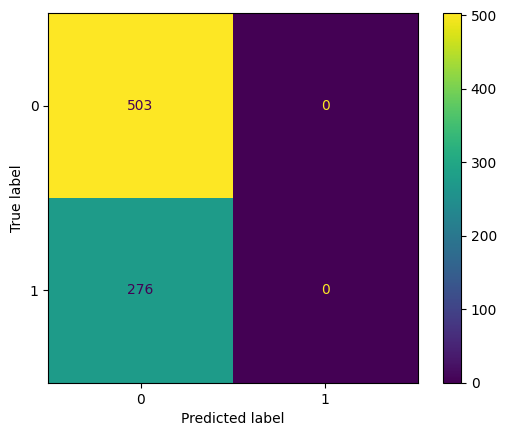

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_baseline)

#### Logistic Regression Model

$$ \text{minimize} \left( -\frac{1}{N} \sum_{i=1}^N \left( y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}i) \right) + \frac{\lambda}{2} \sum{i} w_i^2 \right) $$

In [15]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# initialize the model
log_reg = LogisticRegression(max_iter=1000)

# fit the model
log_reg.fit(X_train_vec, y_train)

# predict
y_pred = log_reg.predict(X_test_vec)


In [16]:
# metrics
from sklearn.metrics import classification_report

# classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.96      0.92       503
           1       0.91      0.75      0.82       276

    accuracy                           0.89       779
   macro avg       0.89      0.86      0.87       779
weighted avg       0.89      0.89      0.88       779



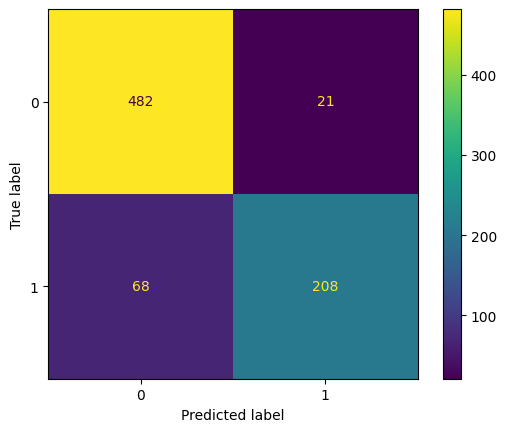

In [17]:
# confusion matrix display
from sklearn.metrics import ConfusionMatrixDisplay

# display
ConfusionMatrixDisplay.from_estimator(log_reg, X_test_vec, y_test)


In [18]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       503
           1       0.91      0.75      0.82       276

    accuracy                           0.89       779
   macro avg       0.89      0.86      0.87       779
weighted avg       0.89      0.89      0.88       779



#### Naive Bayes Classifier

This model is far too harsh on the predictions. Resampling or callibrating the model can show better results.

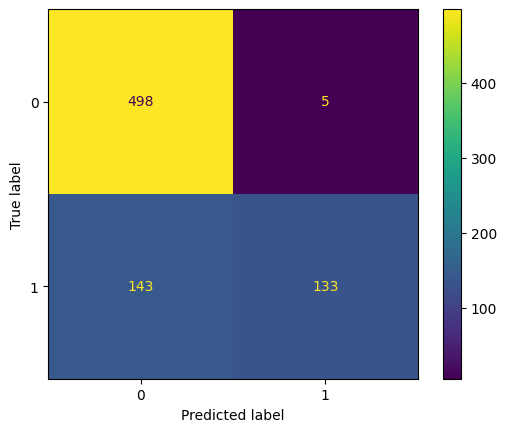

In [19]:
# make naive bayes classifier
from sklearn.naive_bayes import MultinomialNB

# initialize the model
nb = MultinomialNB()

# fit the model
nb.fit(X_train_vec, y_train)

# predict
y_pred_nb = nb.predict(X_test_vec)

# new confusion matrix display
ConfusionMatrixDisplay.from_estimator(nb, X_test_vec, y_test)

In [20]:
# classification report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87       503
           1       0.96      0.48      0.64       276

    accuracy                           0.81       779
   macro avg       0.87      0.74      0.76       779
weighted avg       0.84      0.81      0.79       779



#### Random Forest Model

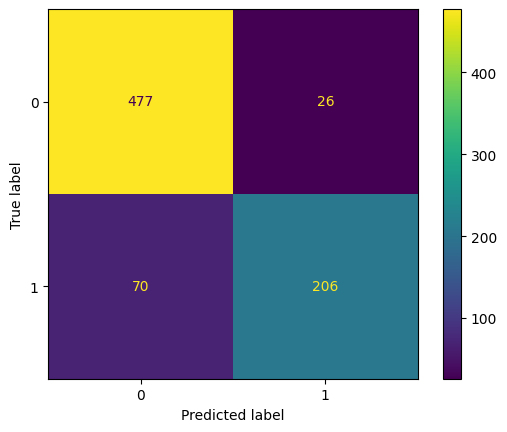

In [21]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier

# initialize the model
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train_vec, y_train)

# predict
y_pred_rf = rf.predict(X_test_vec)

# new confusion matrix display
ConfusionMatrixDisplay.from_estimator(rf, X_test_vec, y_test)

In [22]:
# classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       503
           1       0.89      0.75      0.81       276

    accuracy                           0.88       779
   macro avg       0.88      0.85      0.86       779
weighted avg       0.88      0.88      0.87       779



#### LightGBM Classifier

c:\Users\ryans\Desktop\british_airways\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1178, number of negative: 1937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52296
[LightGBM] [Info] Number of data points in the train set: 3115, number of used features: 1633
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378170 -> initscore=-0.497322
[LightGBM] [Info] Start training from score -0.497322


c:\Users\ryans\Desktop\british_airways\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ryans\Desktop\british_airways\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


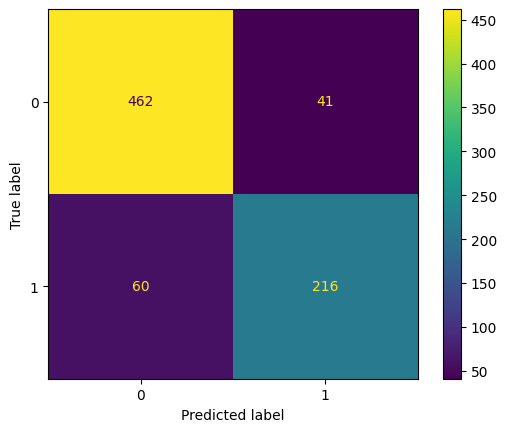

In [23]:
# LightBGM classifier
from lightgbm import LGBMClassifier

# initialize the model
lgbm = LGBMClassifier()

# fit the model
lgbm.fit(X_train_vec, y_train)

# predict
y_pred_lgbm = lgbm.predict(X_test_vec)

# new confusion matrix display
ConfusionMatrixDisplay.from_estimator(lgbm, X_test_vec, y_test)

In [24]:
# classification report
print(classification_report(y_test, y_pred_lgbm))


              precision    recall  f1-score   support

           0       0.89      0.92      0.90       503
           1       0.84      0.78      0.81       276

    accuracy                           0.87       779
   macro avg       0.86      0.85      0.86       779
weighted avg       0.87      0.87      0.87       779



#### Ensemble

In [25]:
# majority vote ensemble
from sklearn.ensemble import VotingClassifier

# create a voting classifier
voting_classifier = VotingClassifier(
    estimators= [
        ('lr', log_reg),
        ('bayes', nb),
        ('lightgbm', lgbm),
        ('rf', rf)
    ], voting='hard'
)


c:\Users\ryans\Desktop\british_airways\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1178, number of negative: 1937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52296
[LightGBM] [Info] Number of data points in the train set: 3115, number of used features: 1633
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378170 -> initscore=-0.497322
[LightGBM] [Info] Start training from score -0.497322


c:\Users\ryans\Desktop\british_airways\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ryans\Desktop\british_airways\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


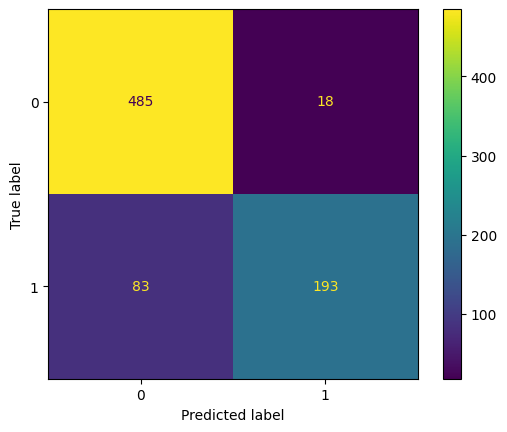

In [26]:
# fit the voting classifier
voting_classifier.fit(X_train_vec, y_train)

# predict
y_pred_vote = voting_classifier.predict(X_test_vec)

# confusion matrix
# new confusion matrix display
ConfusionMatrixDisplay.from_estimator(voting_classifier, X_test_vec, y_test)

In [27]:
print(classification_report(y_test, y_pred_vote))

              precision    recall  f1-score   support

           0       0.85      0.96      0.91       503
           1       0.91      0.70      0.79       276

    accuracy                           0.87       779
   macro avg       0.88      0.83      0.85       779
weighted avg       0.88      0.87      0.87       779



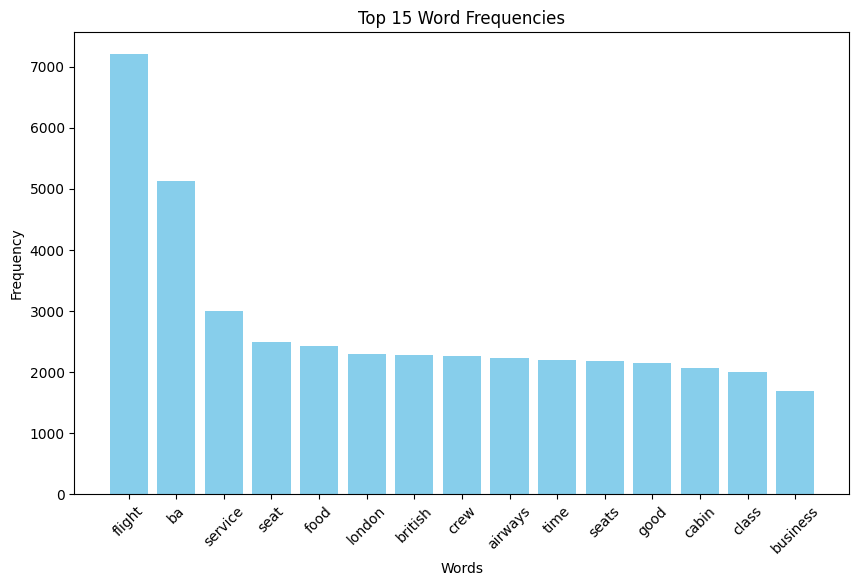

In [34]:
import matplotlib.pyplot as plt
# make a copy of our data
df_copy = df.copy()

# Initialize CountVectorizer for all sentiments
vectorizer_total = CountVectorizer(stop_words='english')

# Fit and transform the text data
X = vectorizer_total.fit_transform(df_copy['review_body'])

# Sum the counts of each word
word_counts = X.toarray().sum(axis=0)

# Create a DataFrame with words and their frequencies
words_df = pd.DataFrame({'word': vectorizer_total.get_feature_names_out(), 'count': word_counts})

# Sort the DataFrame by count in descending order
words_df = words_df.sort_values(by='count', ascending=False)

# Plot the top 10 words
plt.figure(figsize=(10, 6))
plt.bar(words_df['word'][:15], words_df['count'][:15], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Word Frequencies')
plt.xticks(rotation=45)
plt.show()
